# Recurrent Neural Networks

Recurrent layer output for one sample:

$\mathbf{y}_{(t)}=\phi({\mathbf{W}_x}^T\cdot\mathbf{x}_{(t)}+{\mathbf{W}_y}^T\cdot\mathbf{y}_{(t-1)}+\mathbf{b})$

And for all samples:

$\begin{split}
\mathbf{Y}_{(t)}&=\phi(\mathbf{X}_{(t)}\cdot\mathbf{W}_{x}+\mathbf{Y}_{(t-1)}\cdot\mathbf{W}_{y}+\mathbf{b})\\
&=\phi(\left[\mathbf{X}_{(t)}\phantom{X}\mathbf{Y}_{(t-1)}\right]\cdot\mathbf{W}+\mathbf{b})
\end{split}$


with $\mathbf{W}=\left[\begin{array}{c}
\mathbf{W}_x\\
\mathbf{W}_y
\end{array}\right]$

- $\mathbf{Y}_{(t)}$ - matrix $m \times n_{\text{neurons}}$
- $\mathbf{X}_{(t)}$ - matrix $m \times n_{\text{inputs}}$
- $\mathbf{W}_x$ - matrix $n_{\text{inputs}} \times n_{\text{neurons}}$
- $\mathbf{W}_y$ - matrix $n_{\text{neurons}} \times n_{\text{neurons}}$
- $\mathbf{b}$ - vector of size $n_{\text{neurons}}$

## Basic RNN with TensorFlow

In [10]:
def reset_graph():
    tf.reset_default_graph()

In [1]:
import tensorflow as tf

G:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, (None, n_inputs))
X1 = tf.placeholder(tf.float32, (None, n_inputs))

Wx = tf.Variable(tf.random_normal(shape=(n_inputs, n_neurons)), dtype=tf.float32)
Wy = tf.Variable(tf.random_normal(shape=(n_neurons, n_neurons)), dtype=tf.float32)
b = tf.Variable(tf.zeros((1, n_neurons)), dtype=tf.float32)

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [21]:
import numpy as np
                    # sample 0  sample 1   sample 2   sample 3
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])  # t=0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])  # t=1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [24]:
print(Y0_val)

[[ 0.9998845   0.9985211   0.9807717   0.42409754  0.12938699]
 [ 1.          1.          1.         -0.4425541   0.71254337]
 [ 1.          1.          1.         -0.88610226  0.9294788 ]
 [ 0.8929707  -0.2217794   0.9999999  -0.9999985   0.86951333]]


In [23]:
print(Y1_val)

[[ 1.          1.          1.         -0.98594075  0.7372455 ]
 [-0.96119756  0.82696277  0.98419595 -0.7695875  -0.92860484]
 [ 1.          1.          1.         -0.999511   -0.47752377]
 [ 0.9999276   0.9990764   0.99999905 -0.99869365 -0.98094934]]


## ``static_rnn()``

In [27]:
reset_graph()

X0 = tf.placeholder(tf.float32, (None, n_inputs))
X1 = tf.placeholder(tf.float32, (None, n_inputs))

basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [28]:
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [29]:
print(Y0_val)

[[ 0.7775582  -0.9588775   0.583342   -0.8656785   0.06241423]
 [ 0.9999786  -0.9997971   0.9766191  -0.99851596  0.85624963]
 [ 1.         -0.999999    0.99893725 -0.9999847   0.9865007 ]
 [ 0.99998623  0.9961089   0.9988884   0.89188784 -0.7275337 ]]


In [30]:
print(Y1_val)

[[ 1.         -0.99998355  0.9984809  -0.99999183  0.97817904]
 [-0.6203504  -0.33362556  0.00255545 -0.5979532  -0.95510876]
 [ 0.9999995  -0.9990898   0.9862038  -0.99920183  0.40492308]
 [ 0.9997139  -0.18447568  0.9781278  -0.97400355  0.9001233 ]]


Or the much better way to define X:

In [36]:
reset_graph()

n_steps = 2

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))
basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()

In [37]:
X_batch = np.array([
      # t = 0      t = 1
    [[0, 1, 2], [9, 8, 7]],  # sample 0
    [[3, 4, 5], [0, 0, 0]],  # sample 1
    [[6, 7, 8], [6, 5, 4]],  # sample 2
    [[9, 0, 1], [3, 2, 1]]   # sample 3
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [38]:
print(outputs_val)

[[[ 0.78644925  0.23237634  0.7817101  -0.5340793   0.88090867]
  [ 0.85650396  0.99997795  0.99998057  0.99992603  0.9999137 ]]

 [[ 0.9377855   0.9444776   0.99797213  0.6387327   0.9977533 ]
  [-0.08335785  0.90263355  0.24798323  0.8638597  -0.39955902]]

 [[ 0.9829014   0.99738544  0.99998325  0.9709079   0.99996   ]
  [ 0.1397619   0.9996409   0.99957067  0.9998518   0.9657296 ]]

 [[-0.998372    0.9979464  -0.69987684  0.99930674 -0.9833075 ]
  [-0.95189613  0.04853842  0.935623    0.97434515 -0.13885137]]]


## ``dynamic_rnn()``

In [39]:
reset_graph()

X = tf.placeholder(tf.float32, (None, n_steps, n_inputs))
basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [41]:
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [42]:
print(outputs_val)

[[[-0.03482872 -0.2341569  -0.3819376  -0.5550543   0.95308256]
  [-0.6414222   0.98714066  0.99987876 -1.          1.        ]]

 [[-0.4705129   0.6107307   0.6675099  -0.9990505   0.999997  ]
  [ 0.25642464 -0.48041275  0.556726   -0.8514268   0.68712175]]

 [[-0.75591516  0.9300493   0.9650586  -0.9999984   1.        ]
  [-0.6992848   0.9307176   0.9977707  -0.9999994   0.99999994]]

 [[ 0.650494    0.99166745  0.9998903  -0.9981866   0.9995775 ]
  [ 0.38949347  0.890519    0.95712805 -0.9987376   0.9997413 ]]]


### Input sequences with different length

In [44]:
reset_graph()

seq_length = tf.placeholder(tf.int32, (None))

X = tf.placeholder(tf.float32, (None, n_steps, n_inputs))
basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

init = tf.global_variables_initializer()

In [48]:
X_batch = np.array([
      # t = 0      t = 1
    [[0, 1, 2], [9, 8, 7]],  # sample 0
    [[3, 4, 5], [0, 0, 0]],  # sample 1 with vector of zeroes (it means on the t = 1 there is no input)
    [[6, 7, 8], [6, 5, 4]],  # sample 2
    [[9, 0, 1], [3, 2, 1]]   # sample 3
])

seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [49]:
print(outputs_val)

[[[-0.07281392 -0.810872   -0.07239084 -0.8578082   0.7530198 ]
  [-0.833189   -0.9931133   0.99999964  0.9987863   0.99905145]]

 [[-0.39503723 -0.9891931   0.97979647 -0.6916948   0.99109   ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.6425862  -0.9994348   0.9998199  -0.39474493  0.9997158 ]
  [-0.23475975 -0.9548405   0.99985254  0.9993263   0.98874575]]

 [[-0.17676206  0.9956495   0.99999535  0.9999986   0.9998489 ]
  [ 0.03924279 -0.05626582  0.63885915  0.9605177   0.93835074]]]


In [50]:
print(states_val)

[[-0.833189   -0.9931133   0.99999964  0.9987863   0.99905145]
 [-0.39503723 -0.9891931   0.97979647 -0.6916948   0.99109   ]
 [-0.23475975 -0.9548405   0.99985254  0.9993263   0.98874575]
 [ 0.03924279 -0.05626582  0.63885915  0.9605177   0.93835074]]


## Training RNN

In [90]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [91]:
X_train.dtype

dtype('uint8')

In [92]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [93]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [94]:
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [67]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [95]:
reset_graph()

n_inputs = 28
n_steps = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

with tf.name_scope("rnn"):
    X = tf.placeholder(tf.float32, (None, n_steps, n_inputs))
    y = tf.placeholder(tf.int32, (None))

    #basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

    logits = tf.layers.dense(states, n_outputs)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

init = tf.global_variables_initializer()

In [96]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch {}: Training acccuracy = {:.3f}\tTest accuracy = {:.3f}".format(epoch, acc_train, acc_test))

Epoch 0: Training acccuracy = 0.933	Test accuracy = 0.913
Epoch 1: Training acccuracy = 0.933	Test accuracy = 0.952
Epoch 2: Training acccuracy = 0.920	Test accuracy = 0.951
Epoch 3: Training acccuracy = 0.960	Test accuracy = 0.960
Epoch 4: Training acccuracy = 0.973	Test accuracy = 0.970
Epoch 5: Training acccuracy = 0.980	Test accuracy = 0.968
Epoch 6: Training acccuracy = 0.980	Test accuracy = 0.966
Epoch 7: Training acccuracy = 0.980	Test accuracy = 0.970
Epoch 8: Training acccuracy = 0.987	Test accuracy = 0.970
Epoch 9: Training acccuracy = 0.987	Test accuracy = 0.978
Epoch 10: Training acccuracy = 1.000	Test accuracy = 0.973
Epoch 11: Training acccuracy = 0.973	Test accuracy = 0.971
Epoch 12: Training acccuracy = 0.987	Test accuracy = 0.966
Epoch 13: Training acccuracy = 0.980	Test accuracy = 0.967
Epoch 14: Training acccuracy = 0.960	Test accuracy = 0.971
Epoch 15: Training acccuracy = 0.980	Test accuracy = 0.974
Epoch 16: Training acccuracy = 0.987	Test accuracy = 0.967
Epoch 1

## Time Series

In [97]:
import matplotlib.pyplot as plt

In [113]:
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(5 * t)

In [119]:
t_min = 0
t_max = 30
resoltion = 0.1
n_steps = 20

t = np.linspace(t_min, t_max, int((t_max - t_min) / resoltion))
t_batch = np.linspace(12.2, 12.2 + (n_steps + 1) * resoltion, n_steps + 1)

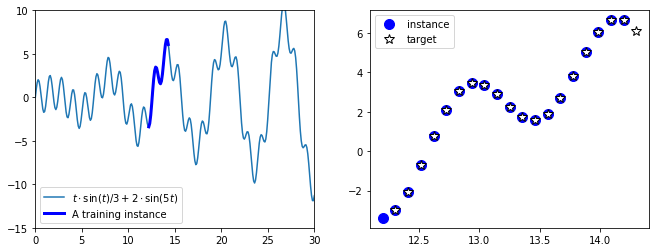

In [130]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(t, time_series(t), label=r"$t\cdot\sin(t) / 3 + 2\cdot\sin(5t)$")
plt.plot(t_batch, time_series(t_batch), 'b-', linewidth=3, label="A training instance")
plt.axis([0, 30, -15, 10])
plt.legend(loc="lower left")

plt.subplot(122)
plt.plot(t_batch[:-1], time_series(t_batch[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_batch[1:], time_series(t_batch[1:]), "w*", markersize=10, markeredgecolor="k", label="target")
plt.legend(loc="upper left");